In [1]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5j75avtu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5j75avtu
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6345240 sha256=a1f8b7fe33aa41697baa5a6a71d6ea070a92a8e15b01a14bd368ddcae8c38637
  Stored in directory: /tmp/pip-ephem-wheel-cache-_wevao1a/wheels/47/e5/15/94c80df2ba85500c

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances

# Register datasets
register_coco_instances("custom_train", {}, "/kaggle/input/coco-ds/COCO_DS/annotations/train_annotations.json", "/kaggle/input/coco-ds/COCO_DS/train")
register_coco_instances("custom_val", {}, "/kaggle/input/coco-ds/COCO_DS/annotations/valid_annotations.json", "/kaggle/input/coco-ds/COCO_DS/valid")
register_coco_instances("custom_test", {}, "/kaggle/input/coco-ds/COCO_DS/annotations/test_annotations.json", "/kaggle/input/coco-ds/COCO_DS/test")

print("Datasets successfully registered!")

Datasets successfully registered!


In [5]:
train_metadata = MetadataCatalog.get("custom_train")
train_dataset_dicts = DatasetCatalog.get("custom_train")

WARNING [02/17 10:39:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/17 10:39:49 d2.data.datasets.coco]: Loaded 3146 images in COCO format from /kaggle/input/coco-ds/COCO_DS/annotations/train_annotations.json


In [6]:
val_metadata = MetadataCatalog.get("custom_val")
val_dataset_dicts = DatasetCatalog.get("custom_val")

WARNING [02/17 10:39:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/17 10:39:49 d2.data.datasets.coco]: Loaded 370 images in COCO format from /kaggle/input/coco-ds/COCO_DS/annotations/valid_annotations.json


In [7]:
test_metadata = MetadataCatalog.get("custom_test")
test_dataset_dicts = DatasetCatalog.get("custom_test")

WARNING [02/17 10:39:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/17 10:39:49 d2.data.datasets.coco]: Loaded 369 images in COCO format from /kaggle/input/coco-ds/COCO_DS/annotations/test_annotations.json


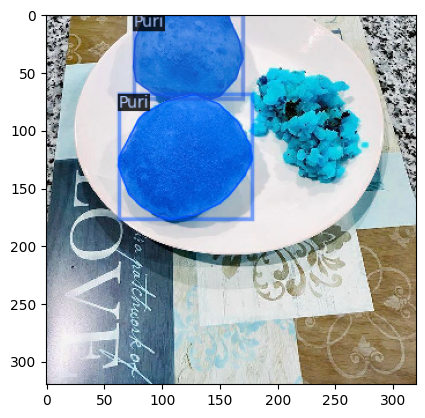

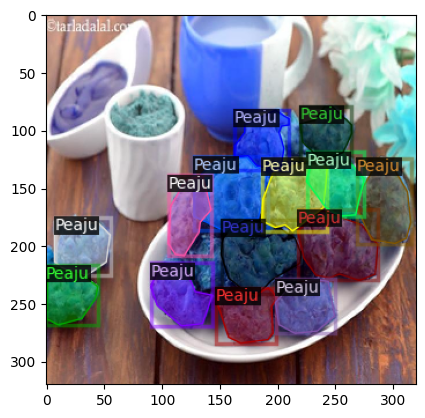

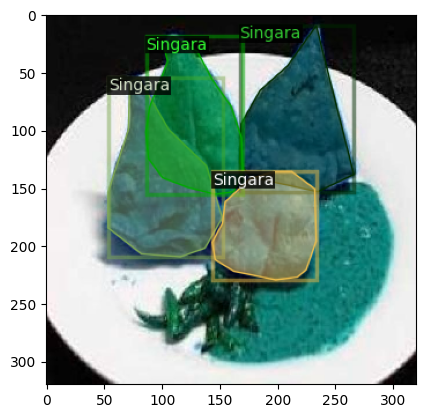

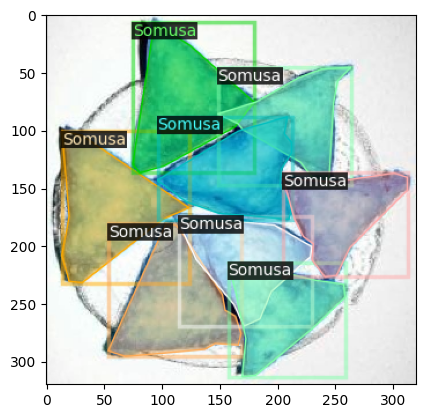

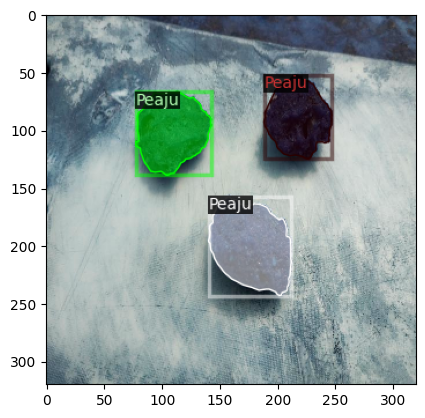

In [8]:
from matplotlib import pyplot as plt
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/kaggle/working/output"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("custom_train",)
cfg.DATASETS.TEST = ("custom_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 10  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.OPTIMIZER = "AdamW"
#cfg.SOLVER.WEIGHT_DECAY = 0.01# Use AdamW optimizer
#cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.solver.build import maybe_add_gradient_clipping
from torch.optim import AdamW

class TrainerWithAdamW(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Builds AdamW optimizer instead of SGD.
        """
        params = maybe_add_gradient_clipping(cfg, model.parameters())
        return AdamW(params, lr=cfg.SOLVER.BASE_LR, weight_decay=cfg.SOLVER.WEIGHT_DECAY)

In [11]:
from detectron2.utils.logger import setup_logger
setup_logger()
trainer = TrainerWithAdamW(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/17 10:39:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_84107b.pkl: 690MB [00:26, 26.0MB/s]                           


[02/17 10:40:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/17 10:41:07 d2.utils.events]:  eta: 5:57:52  iter: 19  total_loss: 3.422  loss_cls: 1.882  loss_box_reg: 0.6881  loss_mask: 0.6883  loss_rpn_cls: 0.1163  loss_rpn_loc: 0.02528    time: 2.1398  last_time: 2.1683  data_time: 0.1271  last_data_time: 0.1313   lr: 1.9981e-06  max_mem: 11688M
[02/17 10:41:59 d2.utils.events]:  eta: 6:00:02  iter: 39  total_loss: 2.781  loss_cls: 1.292  loss_box_reg: 0.702  loss_mask: 0.6844  loss_rpn_cls: 0.07417  loss_rpn_loc: 0.03091    time: 2.1561  last_time: 2.1379  data_time: 0.1181  last_data_time: 0.1196   lr: 3.9961e-06  max_mem: 12114M
[02/17 10:42:43 d2.utils.events]:  eta: 5:59:51  iter: 59  total_loss: 2.217  loss_cls: 0.7112  loss_box_reg: 0.7391  loss_mask: 0.6696  loss_rpn_cls: 0.04539  loss_rpn_loc: 0.02831    time: 2.1608  last_time: 2.1810  data_time: 0.1140  last_data_time: 0.1163   lr: 5.9941e-06  max_mem: 12114M
[02/17 10:43:26 d2.utils.events]:  eta: 5:58:51  iter: 79  total_loss: 1.945  loss_cls: 0.5463  loss_box_reg: 0.7124  loss

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/17 16:39:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

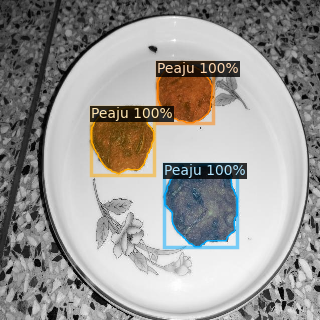

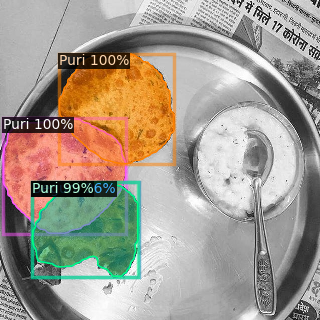

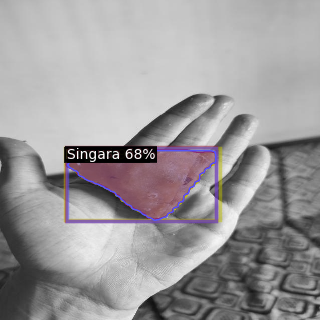

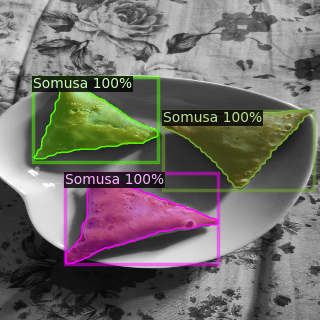

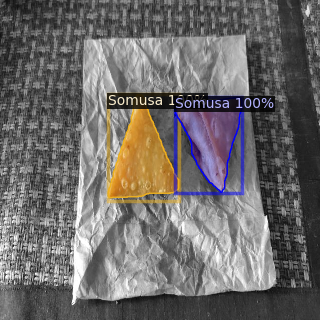

In [13]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 5):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("custom_test", output_dir="/kaggle/working/output/")
val_loader = build_detection_test_loader(cfg, "custom_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [02/17 16:39:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/17 16:39:07 d2.data.datasets.coco]: Loaded 369 images in COCO format from /kaggle/input/coco-ds/COCO_DS/annotations/test_annotations.json
[02/17 16:39:07 d2.data.build]: Distribution of instances among all 7 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| food-wwEy-f.. | 0            |   Beguni   | 203          |    Coin    | 161          |
|     Peaju     | 287          |    Puri    | 144          |  Singara   | 136          |
|    Somusa     | 173          |            |              |            |              |
|     total     | 1104         |            |              |            |              |
[02/17 16:39:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortes

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[02/17 16:39:09 d2.evaluation.evaluator]: Inference done 11/369. Dataloading: 0.0016 s/iter. Inference: 0.1517 s/iter. Eval: 0.0034 s/iter. Total: 0.1568 s/iter. ETA=0:00:56
[02/17 16:39:14 d2.evaluation.evaluator]: Inference done 45/369. Dataloading: 0.0018 s/iter. Inference: 0.1474 s/iter. Eval: 0.0026 s/iter. Total: 0.1519 s/iter. ETA=0:00:49
[02/17 16:39:19 d2.evaluation.evaluator]: Inference done 79/369. Dataloading: 0.0018 s/iter. Inference: 0.1454 s/iter. Eval: 0.0028 s/iter. Total: 0.1501 s/iter. ETA=0:00:43
[02/17 16:39:24 d2.evaluation.evaluator]: Inference done 112/369. Dataloading: 0.0018 s/iter. Inference: 0.1464 s/iter. Eval: 0.0028 s/iter. Total: 0.1512 s/iter. ETA=0:00:38
[02/17 16:39:29 d2.evaluation.evaluator]: Inference done 146/369. Dataloading: 0.0018 s/iter. Inference: 0.1461 s/iter. Eval: 0.0028 s/iter. Total: 0.1507 s/iter. ETA=0:00:33
[02/17 16:39:35 d2.evaluation.evaluator]: Inference done 180/369. Dataloading: 0.0018 s/iter. Inference: 0.1458 s/iter. Eval: 0.